In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json

In [68]:
try:
    df = pd.read_csv('./dataset/final_data.csv')
    print("Successfully loaded the merged dataset.")
except FileNotFoundError:
    print("Error: 'final_merged_crop_weather_data.csv' not found.")
    print("Please make sure you have run the data merging script first.")
    exit()

Successfully loaded the merged dataset.


In [69]:
df['Area'] = df['Area'].replace(0, 1e-9)
df['Yield'] = df['Production'] / df['Area']

In [70]:
initial_rows = len(df)
df.dropna(subset=['Yield'], inplace=True)
print(f"Removed {initial_rows - len(df)} rows with missing Yield values.")

Removed 59 rows with missing Yield values.


In [71]:
y = df['Yield']
y

0        0.121495
1        0.357143
2        0.100000
3        1.287671
4        1.918919
          ...    
7743     0.188446
7744     0.964179
7745     3.177173
7746    13.549107
7747     0.892027
Name: Yield, Length: 7689, dtype: float64

In [72]:
X = df.drop(columns=['Production', 'Yield'])

In [73]:
X = pd.get_dummies(X, columns=['District', 'Season', 'Crop'])
X_columns = X.columns.tolist()
with open('model_columns.json', 'w') as f:
    json.dump(X_columns, f)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining data has {X_train.shape[0]} samples.")
print(f"Testing data has {X_test.shape[0]} samples.")


Training data has 6151 samples.
Testing data has 1538 samples.


In [75]:
print("\nTraining the RandomForestRegressor model...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Model training complete.")

filename = './model/crop_yield_predictor_model.joblib'
joblib.dump(model, filename)

print(f"\nModel saved successfully as '{filename}'")


Training the RandomForestRegressor model...
Model training complete.

Model saved successfully as './model/crop_yield_predictor_model.joblib'


In [76]:
print("\nEvaluating the model on the test data...")
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("\n--- MODEL PERFORMANCE ---")
print(f"The average prediction error (Mean Absolute Error) is: {mae:.2f} tonnes/hectare")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} tonnes/hectare")
print(f"R-squared (R²):               {r2:.2f}")


Evaluating the model on the test data...

--- MODEL PERFORMANCE ---
The average prediction error (Mean Absolute Error) is: 0.76 tonnes/hectare
Root Mean Squared Error (RMSE): 2.83 tonnes/hectare
R-squared (R²):               0.93


In [77]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print("\n--- TOP 10 MOST IMPORTANT FEATURES ---")
print(feature_importances.nlargest(10))


--- TOP 10 MOST IMPORTANT FEATURES ---
Crop_Papaya          0.397642
Crop_Sugarcane       0.359182
Crop_Onion           0.075652
Crop_Tomato          0.020470
Year                 0.018104
Crop_Cabbage         0.015291
Temp_Min_C           0.012117
Area                 0.010083
District_CHITTOOR    0.008959
Crop_Brinjal         0.008639
dtype: float64


In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

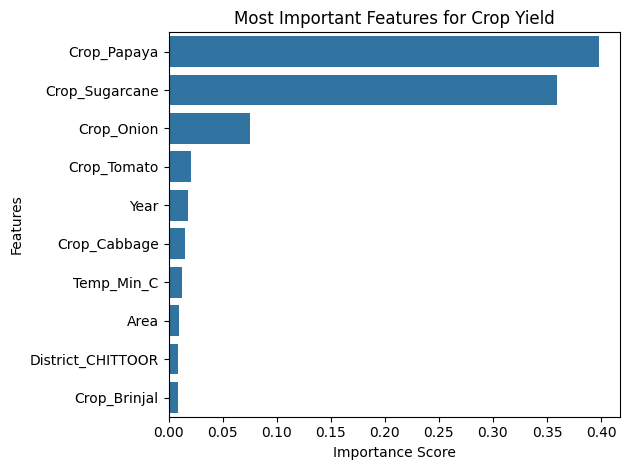

In [79]:
top_features = feature_importances.nlargest(10)
sns.barplot(x=top_features, y=top_features.index)
plt.title('Most Important Features for Crop Yield')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig("./visualization/Most_Important_Features")
plt.show()

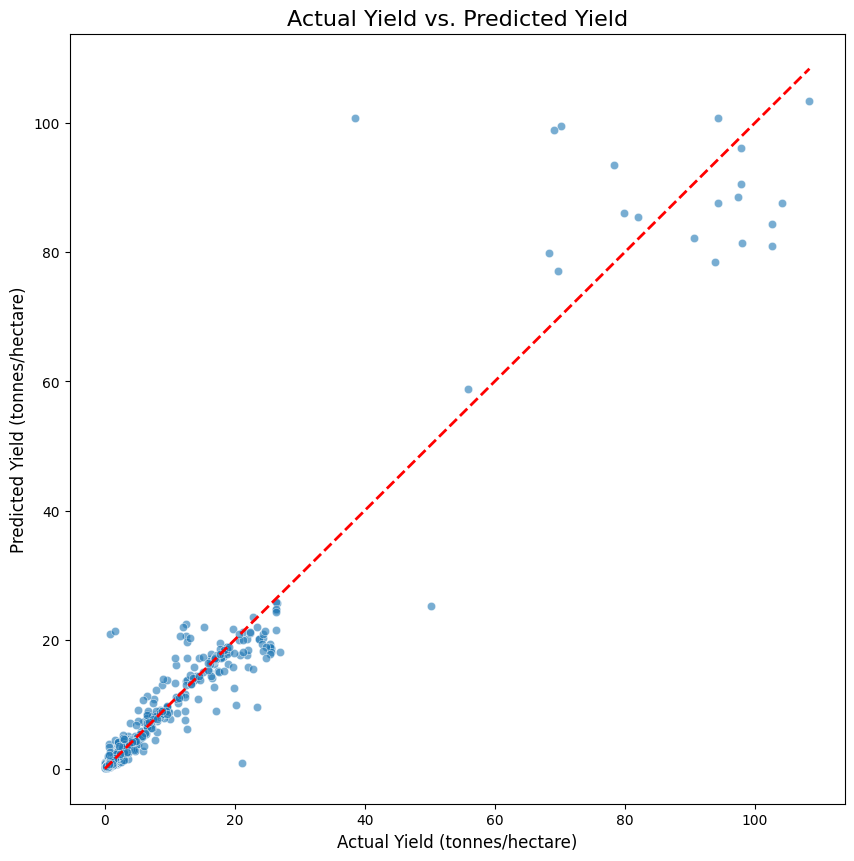

In [80]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual Yield vs. Predicted Yield', fontsize=16)
plt.xlabel('Actual Yield (tonnes/hectare)', fontsize=12)
plt.ylabel('Predicted Yield (tonnes/hectare)', fontsize=12)
plt.savefig('./visualization/actual_vs_predicted_plot.png', dpi=300, bbox_inches='tight')
plt.show()